In [ ]:
import torch 
from setup import fetch_data, idx_to_class 
from plotting import plot_from_dataset, plot_random_image

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# constants 
BATCH_SIZE = 1
IMAGE_SIZE = 128
train_data, test_data, train_dataloader, test_dataloader = fetch_data(batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)
labels_dict = idx_to_class(train_data) 

In [ ]:
plot_from_dataset(train_data, labels_dict, 375); 

In [ ]:
plot_random_image("data/reduced"); 

In [ ]:
# Archicture 1 - TinyVGG 
from torch import nn 
class TinyVGG(nn.Module): 
    def __init__(self, in_shape: int, hidden_units: int, out_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(), 
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) 
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1), 
            nn.ReLU(), 
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=hidden_units*32*32, out_features=out_shape),
        ) 
        
    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))  

In [ ]:
from fitting import train 

model_0 = TinyVGG(in_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  out_shape=len(train_data.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

model_0_results = train(model=model_0, train_dataloader=train_dataloader, test_dataloader=train_dataloader, epochs=4, loss_fn=loss_fn, optimizer=optimizer, device=device)

In [ ]:
from plotting import plot_results

plot_results(model_0_results)

In [ ]:
# test the model on an image it has not seen 
import requests
import pathlib
image_path = pathlib.Path("data/validation/HOUSE SPARROW.jpg")
image_url = "https://cdn.download.ams.birds.cornell.edu/api/v1/asset/612827980/1200"

if not image_path.is_file():
    try: 
        r = requests.get(image_url)
        if r.status_code == 200: 
            with open(image_path, "wb") as f: 
                f.write(r.content)
                print("[INFO] Writing to file...")
    except: 
        print("Exception occurred")

Predicted label: HOUSE SPARROW with 90.19% probability.


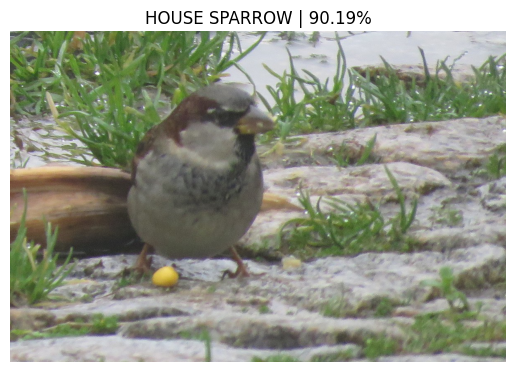

In [31]:
import torchvision
import matplotlib.pyplot as plt
from fitting import predict 

custom_image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255

resizer = torchvision.transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=True) 

probs, prediction = predict(model=model_0, image_tensor=custom_image, transform=resizer, labels_dict=labels_dict, device=device)

plt.imshow(custom_image.to("cpu").permute(1,2,0)) 
plt.axis("off") 
plt.title(f"{prediction} | {probs.max() * 100:.2f}%")
plt.show()

In [39]:
import importlib 
import utils
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\Public\\Documents\\birdifyv0\\utils.py'>

In [40]:
# save
from utils import save_model
model_name = "tinyvgg_v0.pth"
save_model(model_0, model_name)

[INFO] Save successful


In [41]:
# load 
from utils import load_model
model_loaded = TinyVGG(in_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  out_shape=len(train_data.classes)).to(device)
load_model(model_loaded, model_name)

In [45]:
model_loaded.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.2169,  0.1216,  0.0109],
                        [ 0.1843,  0.0305,  0.2182],
                        [-0.0035,  0.0764, -0.0994]],
              
                       [[-0.0940, -0.0877, -0.0845],
                        [ 0.0909, -0.1267, -0.0140],
                        [-0.0735,  0.0741,  0.1576]],
              
                       [[ 0.0936, -0.0066, -0.0631],
                        [-0.0577, -0.0093,  0.1352],
                        [-0.1599, -0.0145, -0.1980]]],
              
              
                      [[[ 0.0006,  0.0725,  0.0946],
                        [-0.0190,  0.0140, -0.1876],
                        [-0.0238, -0.2378, -0.1440]],
              
                       [[-0.1631,  0.1599,  0.1893],
                        [-0.1446,  0.1528, -0.0720],
                        [ 0.1043,  0.1860,  0.0838]],
              
                       [[-0.0640,  0.0134,  0.1115],
                 